Fundamental Fitness is an AI exercise form correction companion to help users perfect their form in any exercise which they workout with. Our AI uses Google Clouds movenet model to help keep track of 17 points on the user's body to accurately identify and compare their form to that of an expert, as well as help identify what they may need to correct.


# FundamentalFitness AI

## Base Setup

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs
!pip install gTTS
!pip install JavaScript

  Preparing metadata (setup.py) ... done


In [ ]:
#Imports (This code was written on google collab, however import files in other code editors as necessary)
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
from IPython.display import HTML
import time
import io
import PIL
from IPython.display import display, Javascript, Image, Audio
from base64 import b64decode, b64encode
from google.colab.output import eval_js
import html
from gtts import gTTS
import sys
import os

In [ ]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))

  # print(keypoints_xy)
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Movenet Model

In [ ]:
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    print(keypoints_with_scores)
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

Run Program With Live Stream (Squats)

<IPython.core.display.Javascript object>

100
35
[1, 670.8261, 390.5281, 687.94604, 372.18622, 655.7704, 376.3709, 712.1765, 388.2178, 637.84204, 393.32974, 747.4153, 474.7788, 637.9495, 490.56165, 749.60376, 621.4606, 636.74164, 605.36676, 709.4685, 731.9695, 627.0735, 711.58093, 706.1553, 718.855, 633.57996, 720.35223, 721.95447, 925.88696, 663.85266, 919.53156, 725.7384, 1099.4061, 676.0198, 1064.0326]
100
35
[1, 557.9009, 601.31744, 571.3951, 582.4857, 564.24445, 585.9109, 624.7082, 582.928, 610.3112, 588.2195, 688.1436, 649.6683, 604.3141, 651.0797, 632.5369, 764.6778, 580.92175, 726.91534, 499.38535, 756.87244, 497.89975, 747.62726, 808.5346, 804.68933, 734.98035, 804.08435, 706.39417, 931.4155, 591.9705, 903.5043, 721.1262, 1105.2858, 641.9101, 1057.9224]
100
35
[1, 631.44354, 407.91718, 646.52045, 387.331, 634.92706, 389.9972, 694.60394, 390.27542, 667.9182, 391.85626, 744.5143, 466.29437, 660.64667, 492.90466, 716.4917, 604.1956, 666.7407, 620.03424, 605.75934, 576.6122, 586.4899, 596.16675, 717.838, 705.9024, 660.939

<ipython-input-3-8c55248dfdaf>:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
<ipython-input-5-ae960629f733>:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))


100
35
[1, 612.7157, 408.38843, 629.3531, 386.7761, 619.69507, 387.96368, 675.6042, 389.14005, 657.0812, 388.50616, 717.68396, 467.74927, 670.92847, 479.55566, 728.2667, 611.81494, 681.38214, 609.34045, 625.5755, 605.5362, 601.9706, 606.3963, 715.6488, 709.7853, 678.4384, 711.0336, 713.9722, 899.33606, 679.5128, 888.6893, 732.2041, 1098.4963, 694.95795, 1052.633]
100
35
[1, 587.92267, 411.7202, 607.7058, 389.16418, 583.92084, 392.2953, 648.12427, 400.24036, 598.5046, 404.54382, 690.4293, 483.39188, 617.06934, 499.3185, 714.027, 617.39856, 623.8008, 603.9184, 622.34894, 629.87573, 537.9272, 610.7348, 699.5862, 722.76294, 640.5925, 724.81067, 697.17773, 907.4551, 642.1646, 892.3117, 726.04346, 1100.5034, 660.9385, 1057.2433]
100
35
[1, 535.71594, 600.8659, 549.99927, 584.23956, 540.7746, 586.8285, 609.3418, 594.0115, 583.31036, 596.18115, 662.3695, 669.5505, 583.8154, 672.0867, 627.5103, 790.6576, 581.0058, 756.5735, 532.89905, 788.2268, 504.50238, 788.07855, 785.1258, 814.1871, 709.0302

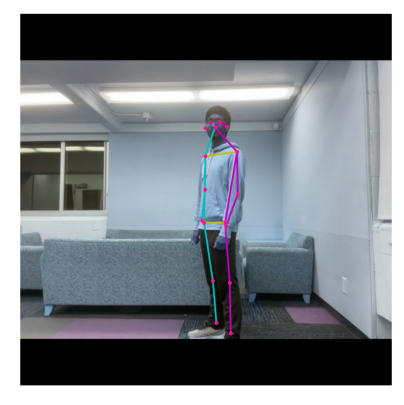

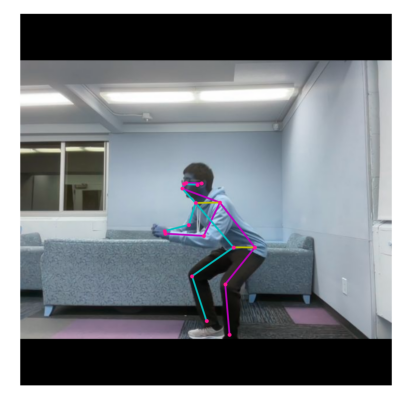

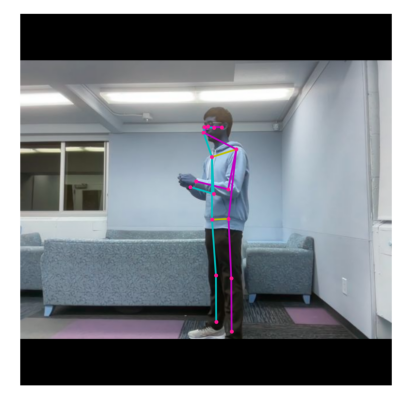

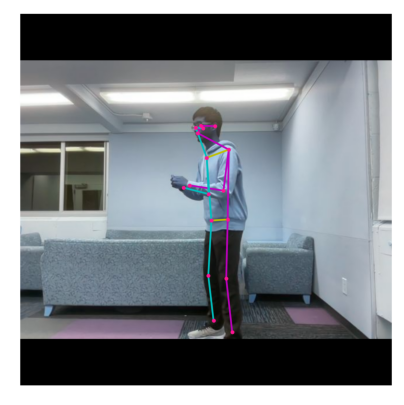

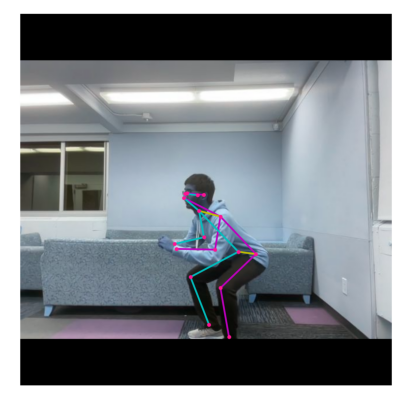

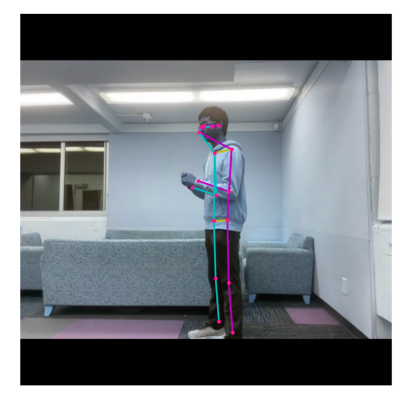

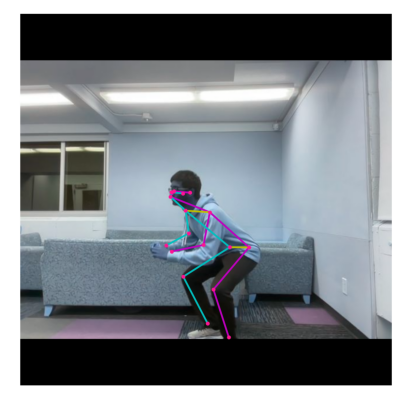

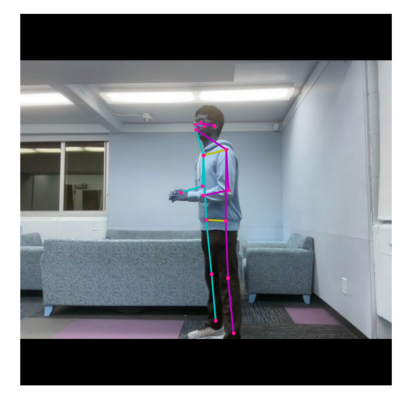

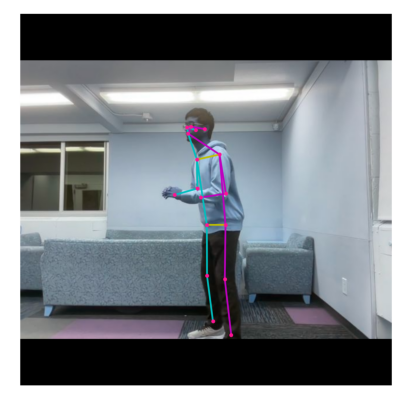

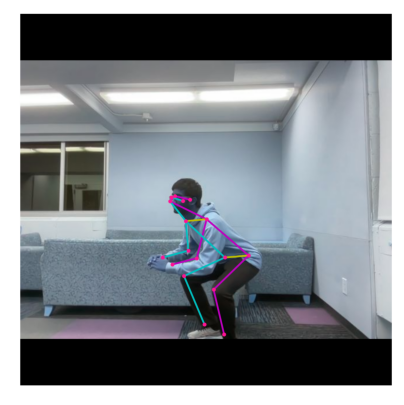

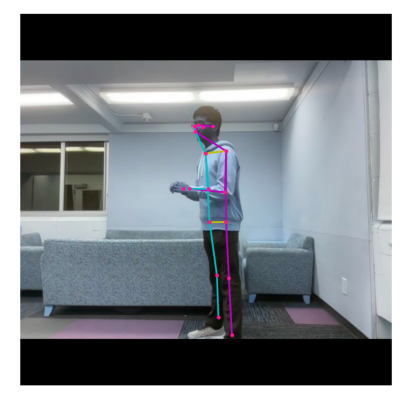

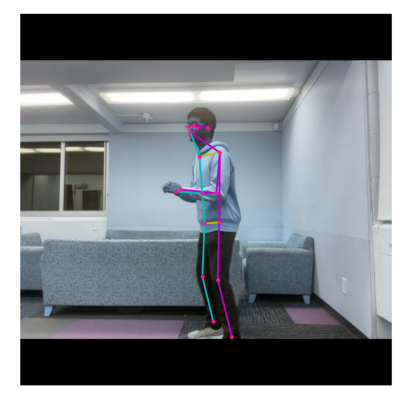

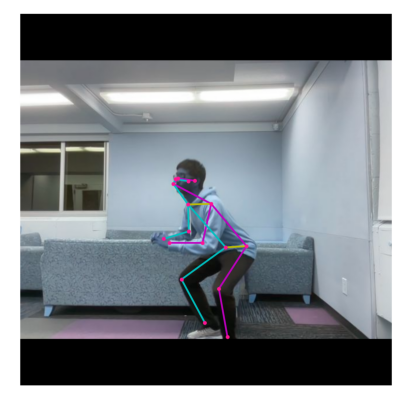

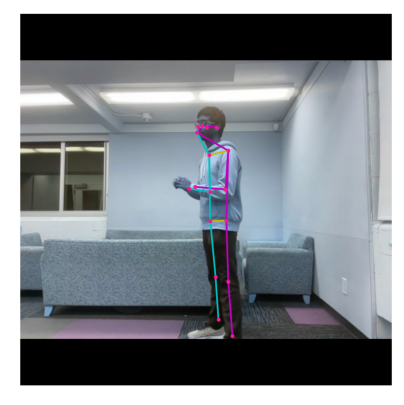

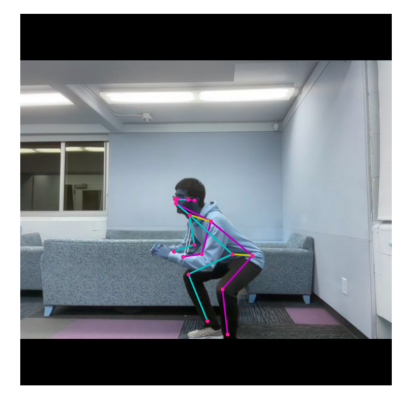

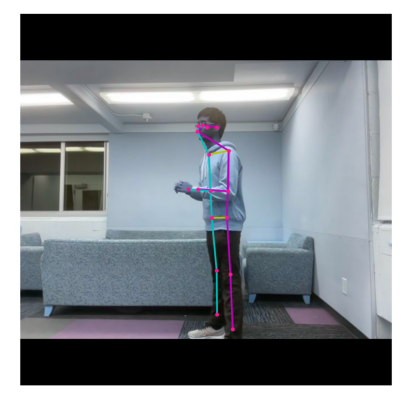

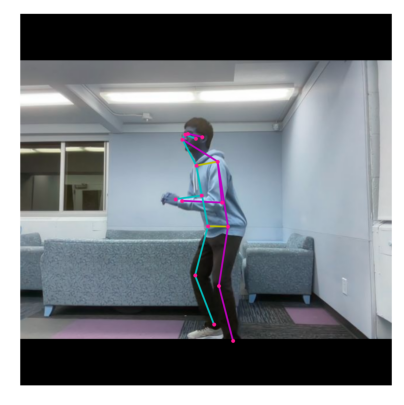

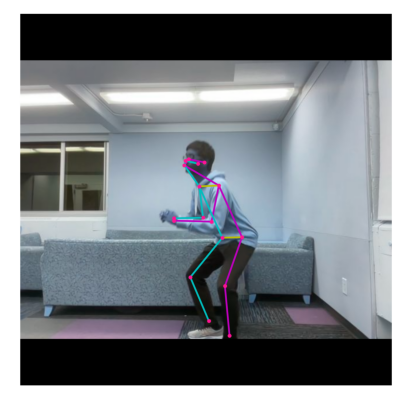

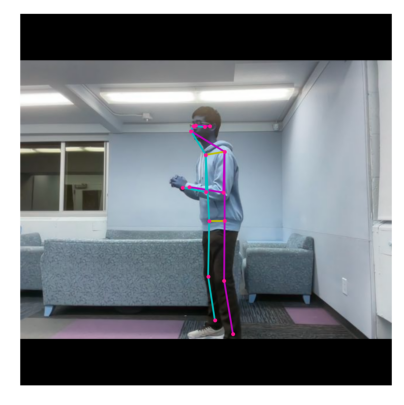

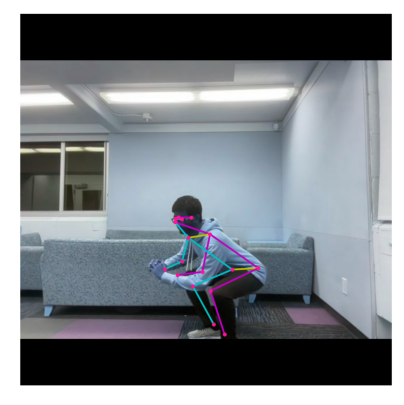

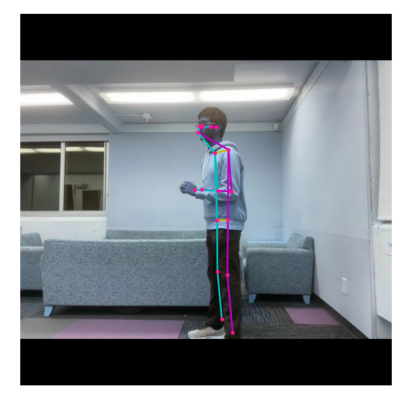

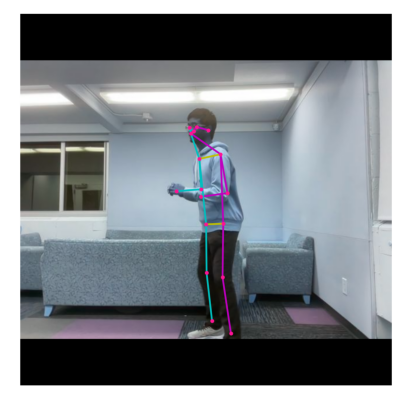

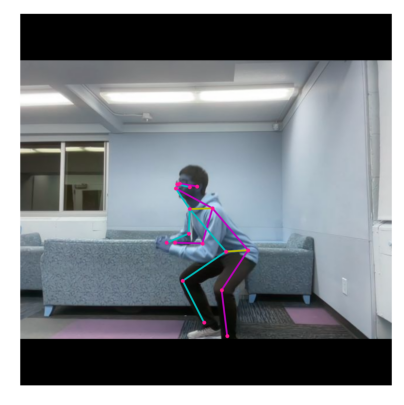

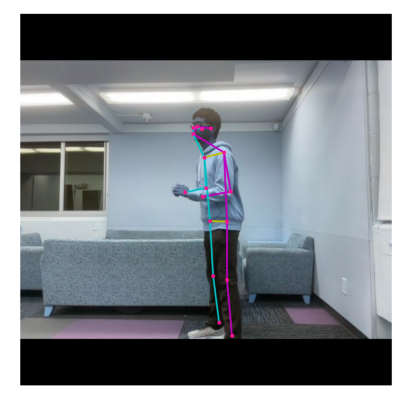

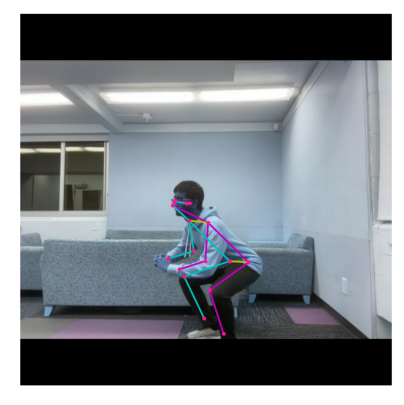

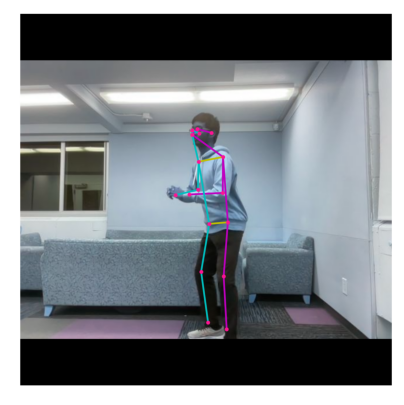

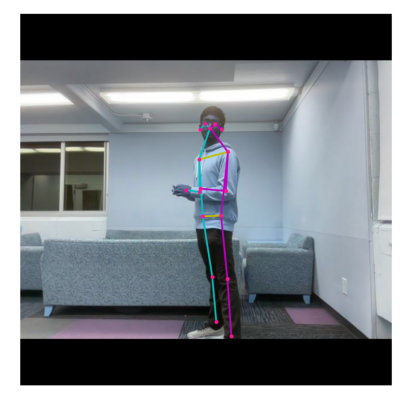

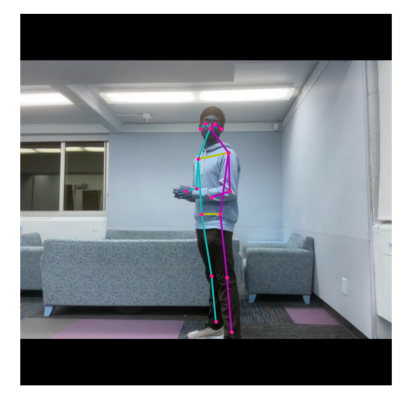

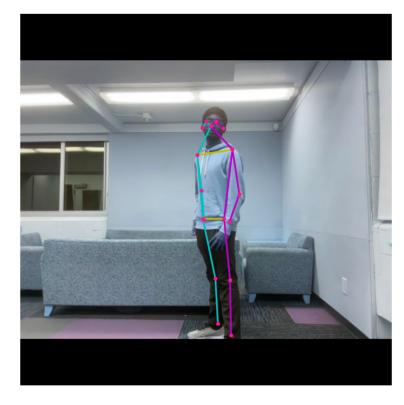

In [ ]:
#Variables Assignment
num_of_faces = 0
num_of_pictures_taken = 0
minutes_running = 3
end_time = time.time() + 60 * minutes_running

# function to convert the JavaScript object into an OpenCV image
def js2img(jsr):
  iwizbyts = b64decode(jsr.split(',')[1])
  jpgnp = np.frombuffer(iwizbyts, dtype=np.uint8)
  img = cv2.imdecode(jpgnp, flags=1)
  return img
def qb2byts(qbra):
  qbtablet = PIL.Image.fromarray(qbra, 'RGBA')
  strongEyes = io.BytesIO()
  qbtablet.save(strongEyes, format='png')
  qbbyts = 'data:image/png;base64,{}'.format((str(b64encode(strongEyes.getvalue()), 'utf-8')))
  return qbbyts


# Functions for starting Stream with Webcam
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

def video_stream():
  js = Javascript('''
    var stream;
    var video;
    var rstrt;
    var iwizperiodic;
    var div = null;
    var unfinished = null;
    var stopp = false;
    var titleperiodic;

    function rmD() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       iwizperiodic = null;
       rstrt = null;
       titleperiodic = null;
    }

    function animeFr() {
      if (!stopp) {
        window.requestAnimationFrame(animeFr);
      }
      if (unfinished) {
        var mark = "";
        if (!stopp) {
          rstrt.getContext('2d').drawImage(video, 0, 0, 640, 480);
          mark = rstrt.toDataURL('image/jpeg', 0.8)
        }
        var pl = unfinished;
        unfinished = null;
        pl(mark);
      }
    }

    async function crD() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const mohit = document.createElement('div');
      mohit.innerHTML = "<span>Status:</span>";
      titleperiodic = document.createElement('span');
      titleperiodic.innerText = 'No data';
      titleperiodic.style.fontWeight = 'bold';
      mohit.appendChild(titleperiodic);
      div.appendChild(mohit);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { stopp = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      iwizperiodic = document.createElement('img');
      iwizperiodic.style.position = 'absolute';
      iwizperiodic.style.zIndex = 1;
      iwizperiodic.onclick = () => { stopp = true; };
      div.appendChild(iwizperiodic);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'Click on the video or this text to end</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { stopp = true; };

      video.srcObject = stream;
      await video.play();

      rstrt = document.createElement('canvas');
      rstrt.width = 640; //video.videoWidth;
      rstrt.height = 480; //video.videoHeight;
      window.requestAnimationFrame(animeFr);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (stopp) {
        rmD();
        stopp = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await crD();

      var preShow = Date.now();
      if (label != "") {
        titleperiodic.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        iwizperiodic.style.top = videoRect.top + "px";
        iwizperiodic.style.left = videoRect.left + "px";
        iwizperiodic.style.width = videoRect.width + "px";
        iwizperiodic.style.height = videoRect.height + "px";
        iwizperiodic.src = imgData;
      }

      var preCapture = Date.now();
      var mark = await new Promise(function(resolve, reject) {
        unfinished = resolve;
      });
      stopp = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': mark};
    }
    ''')

  display(js)

# Manipulates in the input data
def normalize(L):
  # given a list of numbers L, normalize it so all examples are
  # treated on a commensurate basis

  totalLength = 0
  centered_x = 0
  centered_y = 0

  for i in range(17):
    x_i = L[2 * i + 1]
    y_i = L[2 * i + 1 + 1]

    centered_x += x_i
    centered_y += y_i

  centered_x /= 17
  centered_y /= 17
  # print(str(centered_x) + " " + str(centered_y))

  for i in range(17):
    x_i = L[2 * i + 1] - centered_x
    y_i = L[2 * i + 1 + 1] - centered_y

    totalLength += np.sqrt(x_i**2 + y_i**2)

  answer = []
  answer.append(L[0])

  checkerLength = 0

  for i in range(17):
    x_i = L[2 * i + 1] - centered_x
    y_i = L[2 * i + 1 + 1] - centered_y

    localLength = np.sqrt(x_i**2 + y_i**2)
    vectorLength = localLength / totalLength

    unitVectorX_i = x_i / localLength
    unitVectorY_i = y_i / localLength

    answer.append(unitVectorX_i * vectorLength)
    answer.append(unitVectorY_i * vectorLength)
    checkerLength += vectorLength

  return answer

W = [-4.325657666816052, 0.08950988296523274, 0.2602615118602717, 0.09168778116347012, 0.2833736578201197, 0.08851209244449602, 0.2730213068764441, 0.03377786910176586, 0.2829417705077817, 0.044586852917931206, 0.28011183885977026, -0.056148143356378015, 0.18864196696604113, -0.02903514855283025, 0.19045440244384626, 0.018195586510948762, 0.01261177001665899, 0.03788696504963289, 0.03959836340755398, 0.12405132448563677, -0.0004533561232031207, 0.11884561233286743, 0.00893631774601232, -0.21652737025209765, -0.13717378206275407, -0.17609551346401248, -0.11537971424494572, 0.024653062721093397, -0.25369415095237674, 0.042377792711076015, -0.22879769502099515, -0.129253889915888, -0.5657603309523151, -0.10701182719630813, -0.5186349668198829]
P = [-3.416517163139581, -21.35578982291039, 15.294807287857722, -0.04446693184347948, 17.654806670742797, -21.405631908319723, 16.747640832754694, -0.006437738462491961, 11.96924658098809, -18.395037143828063, 10.38748343415219, -2.220676834411694, -2.7379735227710653, -1.887111081873324, -5.867522019037623, 10.692063278138463, 9.24797879387239, 8.8881291018652, 2.0018978882708645, 10.232955313849718, -16.92051006100624, 10.4495186854179, -13.42190284613647, -19.523003680479434, 16.79710045762282, 0.2498507719518179, 16.40767254150967, -17.499930083863376, 19.49555831355778, -0.4482036419241091, 19.620184048129254, -10.181590096181084, 15.884887923153764, -9.069319310498997, 15.56784735525869]
# we train S?
# W = []


# Computes the probability as a percent that the squat is good given a normalized L
def probability(L):
  dot_product = 0
  for i in range(0, 35):
    dot_product += L[i] * W[i]

  output = 1/(1 + np.exp(dot_product)) * 100
  output = (output - 99)/1 * 20 * 2.5 * 100

  if output < 0:
    output = 0

  if output > 100:
    output = 100

  return output

def probabilityPlank(L):
  dot_product = 0
  for i in range(0, 35):
    dot_product += L[i] * P[i]

  output = 1/(1 + np.exp(dot_product)) * 100

  return output

#Python Speech Function
def speak(text: str):
    tts = gTTS(text=text, lang="en")
    filename = "sound.mp3"
    tts.save(filename)
    Audio(filename, autoplay = True)

#Start Code
video_stream()
label_html = 'Live Stream is running...'
bbox = ''
count = 0
img_array = []
running_sum = 0
running_count = 0

while (time.time() < end_time):
    jsr = video_frame(label_html, bbox)
    if not jsr:
        break
    image = js2img(jsr["img"])
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    # print(keypoints_with_scores)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    plt.figure(figsize=(5, 5))
    img_array.append(output_overlay)
    plt.imshow(output_overlay)

    keypointsxy = _keypoints_and_edges_for_display(keypoints_with_scores, 1280, 1280)[0]
    flattendList = []
    flattendList.append(1)

    for i in range(17):
      for j in range(2):
        if len(keypointsxy) > i:
          flattendList.append(keypointsxy[i][j])


    if len(flattendList) != 35:
      lastX = flattendList[len(flattendList)-2]
      lastY = flattendList[len(flattendList)-1]
      while len(flattendList) < 35:
        epsilon = np.random.rand()
        flattendList.append(lastX + epsilon)
        flattendList.append(lastY + epsilon)
    regularizedList = normalize(flattendList)
    goal = probability(regularizedList)
    print(goal)
    if goal > 30:
      running_count += 1
      running_sum += goal

    print(len(flattendList))
    print(flattendList)

    _ = plt.axis('off')
x = 0
if running_count != 0:
  x = float(running_sum/running_count)

val = str('%.2f'%(x))
text = "Your squat form was scored as " + val + " percent of perfection"
print(text)


for i in range(len(img_array)):
   img = img_array[i]
   height, width, layers = img.shape
   size = (width,height)
out = cv2.VideoWriter('video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)




for i in range(len(img_array)):
   out.write(img_array[i])
out.release()

tts = gTTS(text=text, lang="en")
filename = "sound.mp3"
tts.save(filename)
Audio(filename, autoplay = True)

Run Program with Live Stream (plank)

<IPython.core.display.Javascript object>

99.78711046050859
35
[1, 235.8815, 464.81918, 225.06009, 444.62042, 221.70093, 448.4102, 259.3477, 392.2681, 244.3869, 401.35156, 364.61652, 400.4635, 368.10382, 401.52216, 380.65765, 596.8663, 385.26788, 583.0397, 382.93793, 765.9492, 396.593, 739.444, 666.4806, 569.42163, 665.4392, 567.82117, 894.687, 636.7964, 886.9365, 631.4663, 1133.29, 679.60583, 1102.1075, 666.09814]
99.78850951711264
35
[1, 246.3311, 461.51184, 230.92648, 442.80573, 226.68533, 448.3692, 264.15848, 390.56177, 246.08276, 403.04196, 364.84836, 398.13013, 371.6839, 400.88403, 383.3917, 594.1273, 388.01266, 574.9535, 382.27228, 758.6804, 395.7287, 732.8827, 672.3392, 563.08954, 668.84186, 567.46204, 898.2681, 631.58905, 884.1525, 632.72833, 1130.9788, 675.22217, 1091.2261, 674.321]
Your plank form was scored as 99.79 percent of perfection


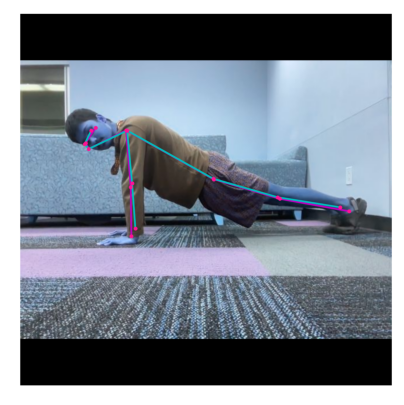

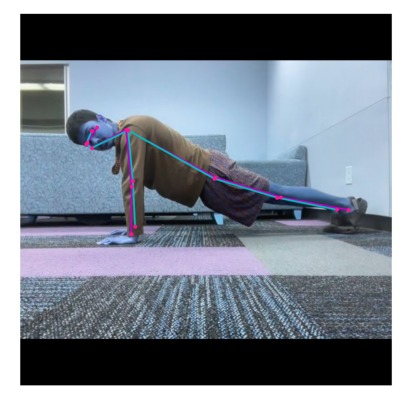

In [ ]:
#Variables Assignment
num_of_faces = 0
num_of_pictures_taken = 0
minutes_running = 3
end_time = time.time() + 60 * minutes_running

# function to convert the JavaScript object into an OpenCV image
def js2img(jsr):
  iwizbyts = b64decode(jsr.split(',')[1])
  jpgnp = np.frombuffer(iwizbyts, dtype=np.uint8)
  img = cv2.imdecode(jpgnp, flags=1)
  return img
def qb2byts(qbra):
  qbtablet = PIL.Image.fromarray(qbra, 'RGBA')
  strongEyes = io.BytesIO()
  qbtablet.save(strongEyes, format='png')
  qbbyts = 'data:image/png;base64,{}'.format((str(b64encode(strongEyes.getvalue()), 'utf-8')))
  return qbbyts


# Functions for starting Stream with Webcam
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

def video_stream():
  js = Javascript('''
    var stream;
    var video;
    var rstrt;
    var iwizperiodic;
    var div = null;
    var unfinished = null;
    var stopp = false;
    var titleperiodic;

    function rmD() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       iwizperiodic = null;
       rstrt = null;
       titleperiodic = null;
    }

    function animeFr() {
      if (!stopp) {
        window.requestAnimationFrame(animeFr);
      }
      if (unfinished) {
        var mark = "";
        if (!stopp) {
          rstrt.getContext('2d').drawImage(video, 0, 0, 640, 480);
          mark = rstrt.toDataURL('image/jpeg', 0.8)
        }
        var pl = unfinished;
        unfinished = null;
        pl(mark);
      }
    }

    async function crD() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const mohit = document.createElement('div');
      mohit.innerHTML = "<span>Status:</span>";
      titleperiodic = document.createElement('span');
      titleperiodic.innerText = 'No data';
      titleperiodic.style.fontWeight = 'bold';
      mohit.appendChild(titleperiodic);
      div.appendChild(mohit);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { stopp = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      iwizperiodic = document.createElement('img');
      iwizperiodic.style.position = 'absolute';
      iwizperiodic.style.zIndex = 1;
      iwizperiodic.onclick = () => { stopp = true; };
      div.appendChild(iwizperiodic);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'Click on the video or this text to end</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { stopp = true; };

      video.srcObject = stream;
      await video.play();

      rstrt = document.createElement('canvas');
      rstrt.width = 640; //video.videoWidth;
      rstrt.height = 480; //video.videoHeight;
      window.requestAnimationFrame(animeFr);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (stopp) {
        rmD();
        stopp = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await crD();

      var preShow = Date.now();
      if (label != "") {
        titleperiodic.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        iwizperiodic.style.top = videoRect.top + "px";
        iwizperiodic.style.left = videoRect.left + "px";
        iwizperiodic.style.width = videoRect.width + "px";
        iwizperiodic.style.height = videoRect.height + "px";
        iwizperiodic.src = imgData;
      }

      var preCapture = Date.now();
      var mark = await new Promise(function(resolve, reject) {
        unfinished = resolve;
      });
      stopp = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': mark};
    }
    ''')

  display(js)

# Manipulates in the input data
def normalize(L):
  # given a list of numbers L, normalize it so all examples are
  # treated on a commensurate basis

  totalLength = 0
  centered_x = 0
  centered_y = 0

  for i in range(17):
    x_i = L[2 * i + 1]
    y_i = L[2 * i + 1 + 1]

    centered_x += x_i
    centered_y += y_i

  centered_x /= 17
  centered_y /= 17
  # print(str(centered_x) + " " + str(centered_y))

  for i in range(17):
    x_i = L[2 * i + 1] - centered_x
    y_i = L[2 * i + 1 + 1] - centered_y

    totalLength += np.sqrt(x_i**2 + y_i**2)

  answer = []
  answer.append(L[0])

  checkerLength = 0

  for i in range(17):
    x_i = L[2 * i + 1] - centered_x
    y_i = L[2 * i + 1 + 1] - centered_y

    localLength = np.sqrt(x_i**2 + y_i**2)
    vectorLength = localLength / totalLength

    unitVectorX_i = x_i / localLength
    unitVectorY_i = y_i / localLength

    answer.append(unitVectorX_i * vectorLength)
    answer.append(unitVectorY_i * vectorLength)
    checkerLength += vectorLength

  return answer

W = [-4.325657666816052, 0.08950988296523274, 0.2602615118602717, 0.09168778116347012, 0.2833736578201197, 0.08851209244449602, 0.2730213068764441, 0.03377786910176586, 0.2829417705077817, 0.044586852917931206, 0.28011183885977026, -0.056148143356378015, 0.18864196696604113, -0.02903514855283025, 0.19045440244384626, 0.018195586510948762, 0.01261177001665899, 0.03788696504963289, 0.03959836340755398, 0.12405132448563677, -0.0004533561232031207, 0.11884561233286743, 0.00893631774601232, -0.21652737025209765, -0.13717378206275407, -0.17609551346401248, -0.11537971424494572, 0.024653062721093397, -0.25369415095237674, 0.042377792711076015, -0.22879769502099515, -0.129253889915888, -0.5657603309523151, -0.10701182719630813, -0.5186349668198829]
P = [-3.416517163139581, -21.35578982291039, 15.294807287857722, -0.04446693184347948, 17.654806670742797, -21.405631908319723, 16.747640832754694, -0.006437738462491961, 11.96924658098809, -18.395037143828063, 10.38748343415219, -2.220676834411694, -2.7379735227710653, -1.887111081873324, -5.867522019037623, 10.692063278138463, 9.24797879387239, 8.8881291018652, 2.0018978882708645, 10.232955313849718, -16.92051006100624, 10.4495186854179, -13.42190284613647, -19.523003680479434, 16.79710045762282, 0.2498507719518179, 16.40767254150967, -17.499930083863376, 19.49555831355778, -0.4482036419241091, 19.620184048129254, -10.181590096181084, 15.884887923153764, -9.069319310498997, 15.56784735525869]
# we train S?
# W = []


# Computes the probability as a percent that the squat is good given a normalized L
def probability(L):
  dot_product = 0
  for i in range(0, 35):
    dot_product += L[i] * W[i]

  output = 1/(1 + np.exp(dot_product)) * 100
  output = (output - 99)/1 * 20 * 2.5 * 100

  if output < 0:
    output = 0

  if output > 100:
    output = 100

  return output

def probabilityPlank(L):
  dot_product = 0
  for i in range(0, 35):
    dot_product += L[i] * P[i]

  output = 1/(1 + np.exp(dot_product)) * 100

  return output

#Python Speech Function
def speak(text: str):
    tts = gTTS(text=text, lang="en")
    filename = "sound.mp3"
    tts.save(filename)
    Audio(filename, autoplay = True)

#Start Code
video_stream()
label_html = 'Live Stream is running...'
bbox = ''
count = 0
img_array = []
running_sum = 0
running_count = 0

while (time.time() < end_time):
    jsr = video_frame(label_html, bbox)
    if not jsr:
        break
    image = js2img(jsr["img"])
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    # print(keypoints_with_scores)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    plt.figure(figsize=(5, 5))
    img_array.append(output_overlay)
    plt.imshow(output_overlay)

    keypointsxy = _keypoints_and_edges_for_display(keypoints_with_scores, 1280, 1280)[0]
    flattendList = []
    flattendList.append(1)

    for i in range(17):
      for j in range(2):
        if len(keypointsxy) > i:
          flattendList.append(keypointsxy[i][j])


    if len(flattendList) != 35:
      lastX = flattendList[len(flattendList)-2]
      lastY = flattendList[len(flattendList)-1]
      while len(flattendList) < 35:
        epsilon = np.random.rand()
        flattendList.append(lastX + epsilon)
        flattendList.append(lastY + epsilon)
    regularizedList = normalize(flattendList)
    goal = probabilityPlank(regularizedList)
    print(goal)
    if goal > 30:
      running_count += 1
      running_sum += goal

    print(len(flattendList))
    print(flattendList)

    _ = plt.axis('off')
x = 0
if running_count != 0:
  x = float(running_sum/running_count)

val = str('%.2f'%(x))
text = "Your plank form was scored as " + val + " percent of perfection"
print(text)


for i in range(len(img_array)):
   img = img_array[i]
   height, width, layers = img.shape
   size = (width,height)
out = cv2.VideoWriter('video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)




for i in range(len(img_array)):
   out.write(img_array[i])
out.release()

tts = gTTS(text=text, lang="en")
filename = "sound.mp3"
tts.save(filename)
Audio(filename, autoplay = True)